# Plots
## Accuracy für KNN 

In [2]:
import numpy as np
import pandas as pnd
import sklearn
from sklearn.metrics import confusion_matrix
from functions.KNN import*

Text(15.8, 0.9221, 'vgg-inspired cnn')

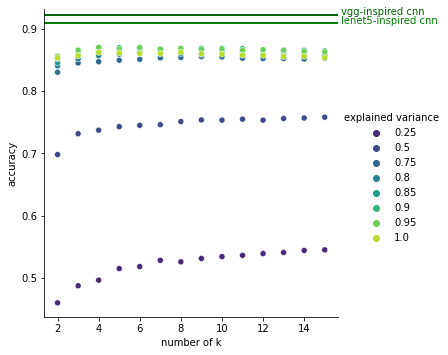

In [3]:
import csv
import seaborn as sns
from scipy import spatial
from scipy.spatial import KDTree
from collections import Counter
from scipy.stats import mode
from functions.PCA import pca
from pathlib import Path
import matplotlib.pyplot as plt
import os
import timeit
from collections import Counter
from scipy.stats import mode
from scipy import spatial
import glob

dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)

testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()

class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

folder_path = 'C:/Users/basti/compmeth2022/topic01_team04/Results/'  # Path to the "results" folder
csv_filess = glob.glob(folder_path + '/*.csv')


totallist = []
for csvdata in csv_filess:
    df = pnd.read_csv(csvdata)
    for i in range(14):
        accuracy = np.sum(df.iloc[:,i] == label_test)/ len(label_test)
        totallist.append(accuracy)
varvec = [0.25,0.5,0.75,0.8,0.85,0.9,0.95,1]
pclist = [i for i in varvec for _ in range(14)]
klist = [i for _ in range(8) for i in range(2,16)]
totallist = pnd.DataFrame({"number of k":klist,"accuracy":totallist,"explained variance":pnd.Categorical(pclist, ordered=True)})

palette = sns.color_palette('viridis', len(totallist['explained variance'].unique()))
variancepcsks = sns.relplot(
data=totallist,
x = 'number of k',
y= 'accuracy',
hue = 'explained variance',
palette = palette
)
plt.axhline(y=0.9085,color="green",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9085, s='lenet5-inspired cnn', color='green')
plt.axhline(y=0.9221,color="darkgreen",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9221, s='vgg-inspired cnn', color='darkgreen')
#plt.savefig('projectsummary.png',dpi=600) 

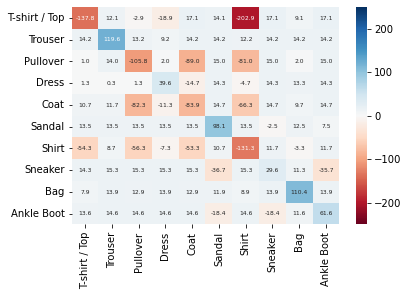

In [4]:
y_pred = pnd.read_csv("C:/Users/basti/compmeth2022/topic01_team04/Results/95var.csv").iloc[:,2]
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = conf_df.astype(float)
rowsums = conf_df.sum(axis=1)
acc = np.sum(y_pred == label_test)/ len(label_test)
for i in range(len(conf_df)):
    for j in range(len(conf_df.columns)):
        if i != j:
            conf_df.values[i,j] -= (1-acc)*rowsums[i]/(len(conf_df)-1)
            conf_df.values[i,j] *= -1
        else: 
            conf_df.values[i,j] -= acc*rowsums[i]
sns.heatmap(conf_df, annot=True, cmap= "RdBu", annot_kws={"fontsize":6},fmt=",.1f",center=0,vmax=250,vmin=-250)
#plt.savefig('knn_chi.png',dpi=600)

In [ ]:
# Confusion Matrix vor k = 4 and PC Variance 95%
dftest = pnd.read_csv('C:/Users/awark/Bioinfo Projekt/Results/95var.csv')
y_pred = np.array(dftest['2'])
y_true = label_test
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = round(conf_df*100 / conf_df.sum(axis=1),2)
print(conf_df)

sns.heatmap(conf_df, annot=True, cmap='RdYlGn')

In [ ]:
listprec = []
listrec = []
listfscore = []
for csvdata in csv_filess:
    dfmeasures = pnd.read_csv(csvdata)
    for i in range(14):
        ypred = dfmeasures.iloc[4]
        prf = precision_recall_fscore_support(y_true, y_pred, average=None, labels=label_test)
        precision=prf[0]
        recall=prf[1]
        fscore=prf[2]       
        listprec.append(precision)
        listrec.append(recall)
        listfscore.append(fscore)


Timeit Befehl: KNN kdtrees gegen KNN

In [15]:
def knn_kdtree(PCs_train, PCs_test, k, label_train, label_test, testsize):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        
    Returns:
        knn for number of testsize images
    """

    result = np.array([])
    kd_tree = spatial.KDTree(PCs_train,leafsize=10)
    count_count = 0
    for i in range(0, len(label_test), testsize):
        if count_count % 10 == 0:
            print("Current progress is " + str(count_count*100/(len(label_test)/testsize)) + " percent.")
        count_count += 1
        dist, neighbour_index = kd_tree.query(PCs_test[i:i+testsize, None],p=2,k=k, workers = -1)
        neighbour_label = label_train[neighbour_index]
        batch_result = [mode(neighbour_label,axis=2)[0]]
        batch_result = np.array(batch_result)
        batch_result = np.squeeze(batch_result)
        batch_result = batch_result.astype(int)
        result = result.astype(int)
        result = np.concatenate((result, batch_result), axis=0)
    return result

knn_kdtree(PCs_test, PCs_test, 4, label_train, label_test, 50)

timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000)

### 1,10,20,50,100


Current progress is 0.0 percent.
Current progress is 5.0 percent.
Current progress is 10.0 percent.
Current progress is 15.0 percent.
Current progress is 20.0 percent.
Current progress is 25.0 percent.
Current progress is 30.0 percent.
Current progress is 35.0 percent.
Current progress is 40.0 percent.
Current progress is 45.0 percent.
Current progress is 50.0 percent.
Current progress is 55.0 percent.
Current progress is 60.0 percent.
Current progress is 65.0 percent.
Current progress is 70.0 percent.
Current progress is 75.0 percent.
Current progress is 80.0 percent.
Current progress is 85.0 percent.
Current progress is 90.0 percent.
Current progress is 95.0 percent.


16.571393799997168

In [16]:
knn_quality(PCs_train, PCs_test, 4, label_train, label_test, 50)
timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000)

Image 5 was classified as Shirt but is actually a(n) Pullover
Image 7 was classified as Dress but is actually a(n) Shirt
Image 30 was classified as Ankle Boot but is actually a(n) Sandal
Image 40 was classified as Shirt but is actually a(n) Pullover
Image 41 was classified as Pullover but is actually a(n) T-shirt / Top


18.220316399994772

In [21]:
def knn_kdtree_mod(PCs_train, PCs_test, k, label_train, label_test, testsize, leafsize):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        
    Returns:
        knn for number of testsize images
    """

    result = np.array([])
    kd_tree = spatial.KDTree(PCs_train,leafsize)
    count_count = 0
    for i in range(0, len(label_test), testsize):
        if count_count % 10 == 0:
            print("Current progress is " + str(count_count*100/(len(label_test)/testsize)) + " percent.")
        count_count += 1
        dist, neighbour_index = kd_tree.query(PCs_test[i:i+testsize, None],p=2,k=k, workers = -1)
        neighbour_label = label_train[neighbour_index]
        batch_result = [mode(neighbour_label,axis=2)[0]]
        batch_result = np.array(batch_result)
        batch_result = np.squeeze(batch_result)
        batch_result = batch_result.astype(int)
        result = result.astype(int)
        result = np.concatenate((result, batch_result), axis=0)
    return result

timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000)

timeit_leafsize = []
leafsizes = np.array([1, 10, 20, 50, 100])
for i in leafsizes:
    knn_kdtree_mod(PCs_train, PCs_test, 4, label_train, label_test, 50, i)
    timeit_leafsize.append(timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000))



Current progress is 0.0 percent.
Current progress is 5.0 percent.
Current progress is 10.0 percent.
Current progress is 15.0 percent.
Current progress is 20.0 percent.
Current progress is 25.0 percent.
Current progress is 30.0 percent.
Current progress is 35.0 percent.
Current progress is 40.0 percent.
Current progress is 45.0 percent.
Current progress is 50.0 percent.
Current progress is 55.0 percent.
Current progress is 60.0 percent.
Current progress is 65.0 percent.
Current progress is 70.0 percent.
Current progress is 75.0 percent.
Current progress is 80.0 percent.
Current progress is 85.0 percent.
Current progress is 90.0 percent.
Current progress is 95.0 percent.
Current progress is 0.0 percent.
Current progress is 5.0 percent.
Current progress is 10.0 percent.
Current progress is 15.0 percent.
Current progress is 20.0 percent.
Current progress is 25.0 percent.
Current progress is 30.0 percent.
Current progress is 35.0 percent.
Current progress is 40.0 percent.
Current progress i

In [47]:
timeit = pnd.DataFrame(timeit_leafsize, index=(['1', '10', '20', '50', '100']),columns=(['timeit']))
print(timeit)


        timeit
1    17.066759
10   16.581535
20   17.073992
50   26.276236
100  52.231134
